# **AdaBoost**

데이터 세트는 일상 사용 시 무거운 Scania 트럭에서 수집된 데이터로 구성된다.
이 시스템은 공기압 시스템(APS)으로, 제동 및 기어 변속과 같은 대차의 다양한 기능에 사용되는 가압 공기를 생성합니다.
데이터 세트의 pos는 APS 시스템의 특정 구성 요소에 대한 구성 요소 장애로 구성됩니다.
neg는 APS와 관련이 없는 구성 요소에 대한 고장이 있는 트럭으로 구성됩니다.
데이터는 전문가들이 선택한 사용 가능한 모든 데이터의 하위 집합으로 구성됩니다.

* 학습 데이터 6만개 / 테스트 데이터 1만 6천개

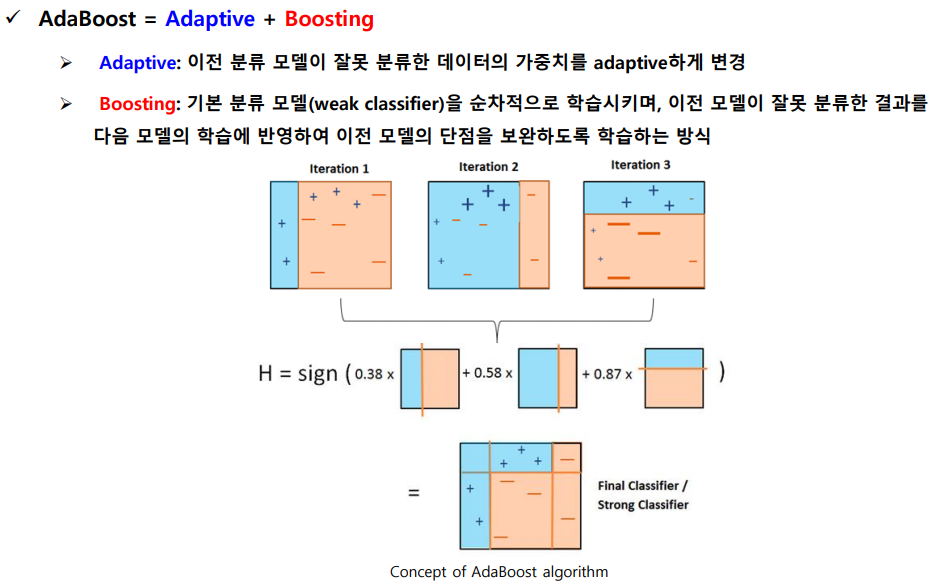

# Boosting the weak learners

In [ ]:
# package 불러오기

import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics         import accuracy_score

In [ ]:
!git clone https://github.com/yun-seon/LGE_DIC_Training_0307.git

Cloning into 'LGE_DIC_Training_0307'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 6), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 7.15 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# import dataset
df_wine = pd.read_csv('/content/LGE_DIC_Training_0307/wine.data', header = None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanolds',
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine = df_wine[df_wine['Class label']!=1] # drop 1 class
df_wine = df_wine.dropna() # drop NA

# encode the data
le = LabelEncoder()

X = df_wine[['Alcohol', 'Hue']].values
y = le.fit_transform(df_wine['Class label'].values)

In [ ]:
# train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
def accuracy( model, X, y ):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

In [ ]:
def decision_regions( models, titles, X, y ):
    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,5))

    for idx, clf, label in zip([0, 1], models, titles):
        #clf.fit(X, y)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axarr[idx].contourf(xx, yy, Z, alpha=0.3)
        axarr[idx].scatter( X[y==0,0], X[y==0,1], c='blue', marker='^', s=50)
        axarr[idx].scatter( X[y==1,0], X[y==1,1], c='red',  marker='o', s=50)
        axarr[idx].set_title(label)

    axarr[0].set_ylabel('Alcohol', fontsize=12)
    plt.text(10,  -0.8, s='Hue',     ha='center', va='center', fontsize=12)
    plt.show()

In [ ]:
# Weak learner 1 (1-depth Decision Tree)

from sklearn.tree         import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
tree = tree.fit(X_train, y_train)

print(f'Decision tree train/test accuracies:{accuracy(tree, X_train, y_train)},{accuracy(tree, X_test,  y_test)}')

Decision tree train/test accuracies:0.8450704225352113,0.8541666666666666


In [ ]:
# Boosting for Weak learner 1 (1-depth Decision Tree)

from sklearn.ensemble import AdaBoostClassifier

ada_tree  = AdaBoostClassifier(estimator=tree,
                               n_estimators=500,
                               learning_rate=0.1,
                               random_state=0)
ada_tree = ada_tree.fit(X_train, y_train)

print(f'AdaBoost for tree train/test accuracies:{accuracy(ada_tree, X_train, y_train)},{accuracy(ada_tree, X_test,  y_test)}')

AdaBoost for tree train/test accuracies:1.0,0.875


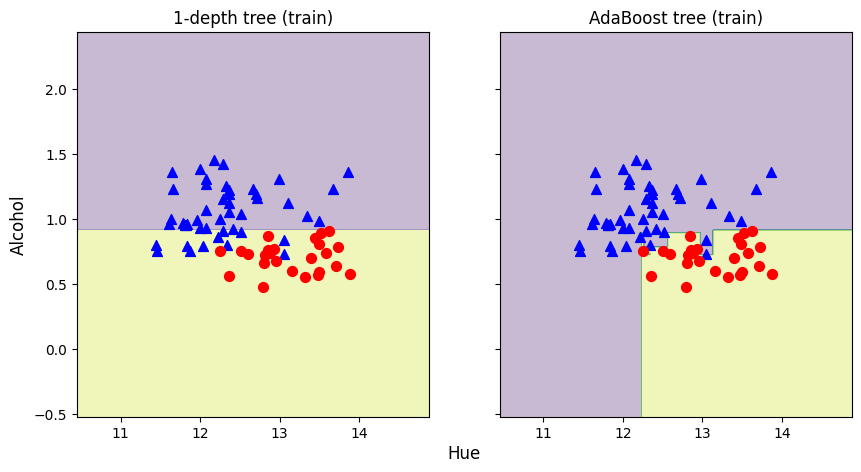

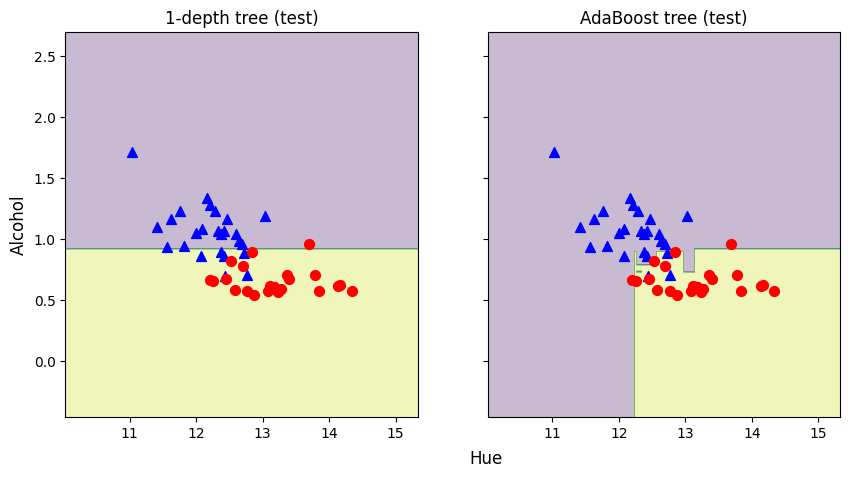

In [ ]:
# visualize the comparisons (Decision Tree vs AdaBoost for tree)

decision_regions([tree, ada_tree], ['1-depth tree (train)', 'AdaBoost tree (train)'], X_train, y_train)
decision_regions([tree, ada_tree], ['1-depth tree (test)', 'AdaBoost tree (test)'],   X_test, y_test)

In [ ]:
# Weak learner 2 (Single perceptron)

from sklearn.linear_model import Perceptron

pla = Perceptron(n_iter_no_change=20, eta0=0.01, random_state=0)
pla.fit(X_train, y_train)
print(f'Perceptron train/test accuracies:{accuracy(pla, X_train, y_train)},{accuracy(pla, X_test,  y_test)}')

Perceptron train/test accuracies:0.8169014084507042,0.8541666666666666


In [ ]:
# Boosting for Weak learner 2 (Single perceptron)

from sklearn.ensemble import AdaBoostClassifier

ada_pla = AdaBoostClassifier(estimator=pla,
                             n_estimators=500,
                             learning_rate=0.1,
                             random_state=0,
                             algorithm='SAMME')
ada_pla = ada_pla.fit(X_train, y_train)

print(f'AdaBoost for perceptron train/test accuracies:{accuracy(ada_pla, X_train, y_train)},{accuracy(ada_pla, X_test,  y_test)}')

AdaBoost for perceptron train/test accuracies:0.9014084507042254,0.9166666666666666


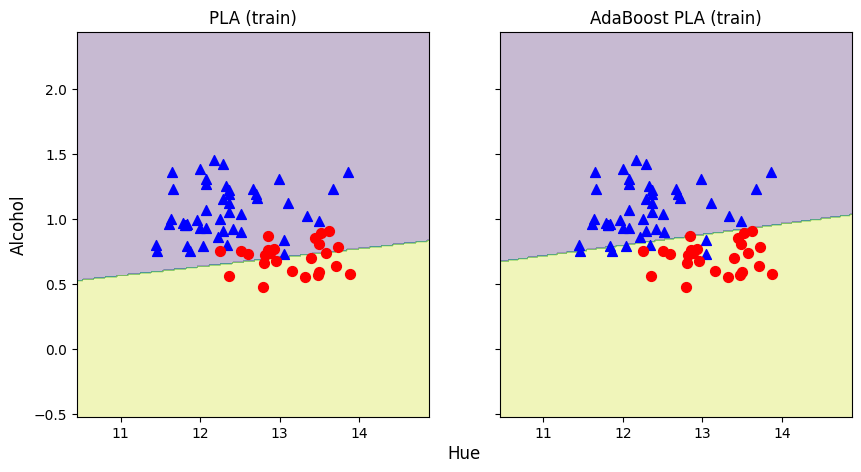

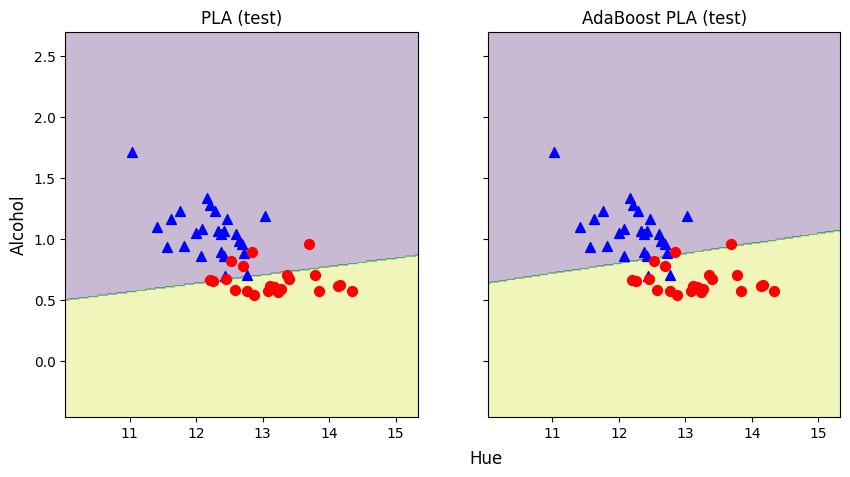

In [ ]:
# visualize the comparisons (Single perceptron vs AdaBoost for perceptron)

decision_regions([pla, ada_pla], ['PLA (train)', 'AdaBoost PLA (train)'], X_train, y_train)
decision_regions([pla, ada_pla], ['PLA (test)',  'AdaBoost PLA (test)'],  X_test, y_test)

## AdaboostClassifier 예제
#### 파라미터 참조 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [ ]:
# import dataset

train_data = pd.read_csv('/content/LGE_DIC_Training_0307/APS_Sensor_Classification_train.csv')
test_data = pd.read_csv('/content/LGE_DIC_Training_0307/APS_Sensor_Classification_test.csv')

del train_data['Unnamed: 0']
del test_data['Unnamed: 0']

train_data.head()

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,label
0,45260.0,442.0,0.0,0.0,0.0,0.0,0.0,100422.0,1655688.0,1108034.0,...,121684.0,226718.0,184050.0,205394.0,858050.0,33222.0,0.0,0.0,0.0,0.0
1,60856.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15354.0,448202.0,...,208040.0,513504.0,563476.0,582422.0,384180.0,97252.0,0.0,0.0,0.0,0.0
2,47534.0,692.0,0.0,0.0,0.0,0.0,0.0,0.0,2070.0,233100.0,...,253092.0,552128.0,449354.0,133876.0,90004.0,175426.0,5278.0,0.0,0.0,0.0
3,79260.0,254.0,0.0,0.0,0.0,0.0,0.0,0.0,31538.0,764866.0,...,593040.0,1762706.0,671518.0,1872.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3144.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,7352.0,164006.0,...,5660.0,15358.0,20668.0,48802.0,31842.0,416.0,0.0,0.0,0.0,0.0


In [ ]:
# X & y split

X_train = train_data.iloc[:, 0:-1]
Y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:, 0:-1]
Y_test = test_data.iloc[:,-1]

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

params = {"n_estimators" : [50, 100, 150], "learning_rate" : [1]}

# model define
model_Ada = AdaBoostClassifier()

# model train with gridsearchCV
grid_model_Ada = GridSearchCV(model_Ada, param_grid = params, cv = 5, refit = True, return_train_score= True)
grid_model_Ada.fit(X_train, Y_train)

# print results
result = pd.DataFrame(grid_model_Ada.cv_results_)

best_model_Ada = grid_model_Ada.best_estimator_

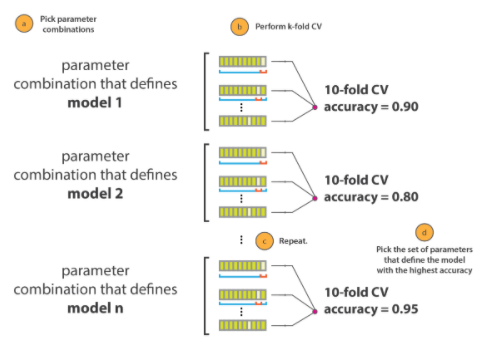

In [ ]:
print("CV score")

result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,"{'learning_rate': 1, 'n_estimators': 50}",0.982699,0.974913,0.974913,0.981834,0.980952,0.003432,0.979062
1,"{'learning_rate': 1, 'n_estimators': 100}",0.985294,0.975779,0.975779,0.981834,0.982684,0.003843,0.980274
2,"{'learning_rate': 1, 'n_estimators': 150}",0.986159,0.979239,0.978374,0.985294,0.982684,0.003123,0.982350


In [ ]:
print("Adaboost")
print("Best Parameter : " + str(grid_model_Ada.best_params_))

# predict
pred = best_model_Ada.predict(X_test)

Adaboost
Best Parameter : {'learning_rate': 1, 'n_estimators': 150}


In [ ]:
# cross table
tab = pd.crosstab(Y_test, pred, rownames = ["real"], colnames = ["pred"])
print(tab)

# Accuracy 직접 연산
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1,1]) / len(X_test)))

pred    0.0  1.0
real            
0.0   14134  118
1.0      22  138
Acc : 0.9902858728837081


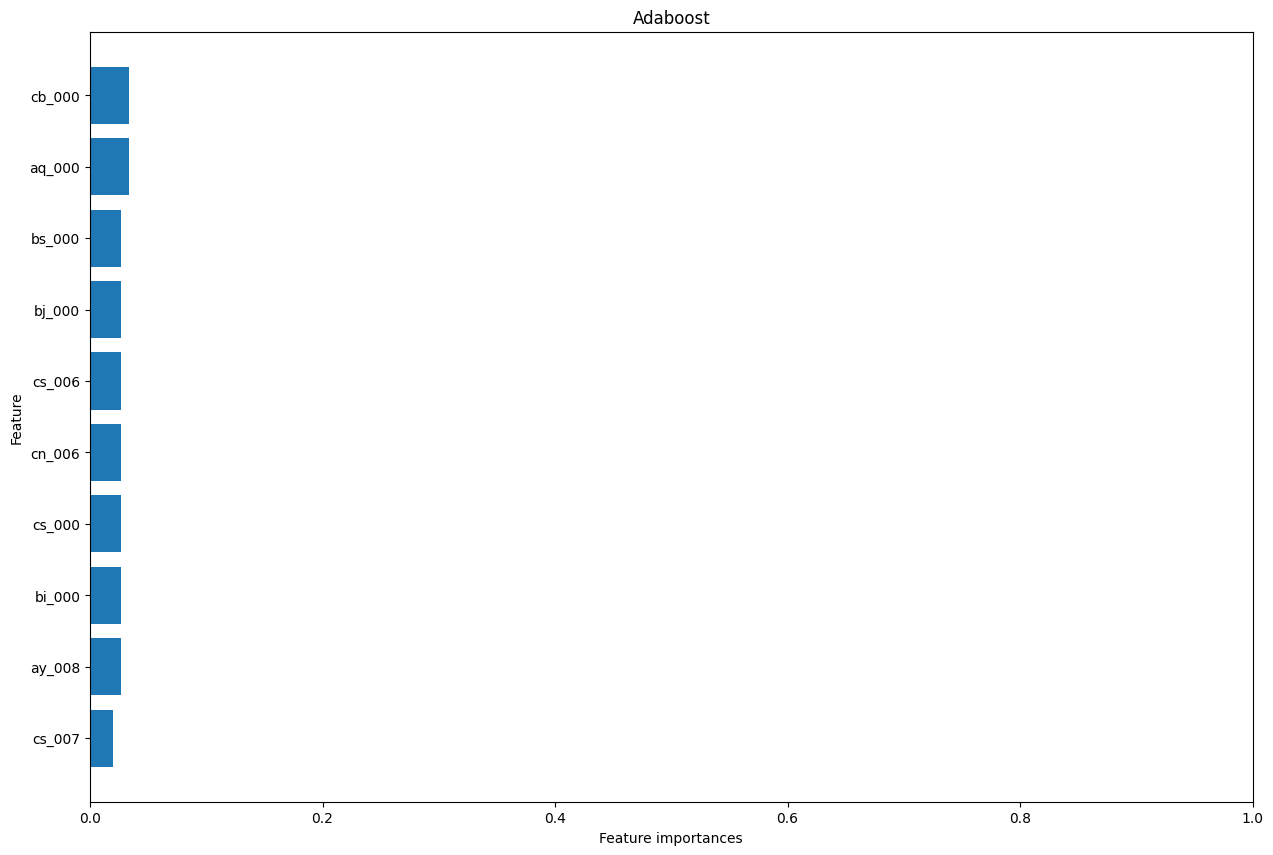

In [ ]:
# visualie the feature importance

plt.figure(figsize = (15, 10))

plt.title("Adaboost")
fi = best_model_Ada.feature_importances_
idx = (-fi).argsort()[0:10]
fi = fi[idx]
idx = X_train.columns[idx]

plt.barh(range(10), fi[::-1], align='center') # ::는 처음부터 끝까지 '특정(-1)' 간격으로 연산하라는 의미
plt.xlim(0, 1)
plt.yticks(range(10), idx[::-1])
plt.xlabel('Feature importances', size=10)
plt.ylabel('Feature', size=10)

plt.show()

## AdaboostRegressor 예제
#### 파라미터 참조 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [ ]:
df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanolds,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
60,2.0,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0
61,2.0,12.33,1.10,2.28,16.0,101.0,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680.0
62,2.0,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0
63,2.0,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0
64,2.0,12.37,1.13,2.16,19.0,87.0,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,3.0,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
175,3.0,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
176,3.0,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
177,3.0,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [ ]:
df_wine.describe()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanolds,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,2.403361,12.631681,2.497815,2.322353,20.713445,96.470588,2.024874,1.556723,0.397479,1.437983,4.824958,0.905597,2.340924,564.033613
std,0.492646,0.685195,1.248867,0.285653,3.004119,14.807135,0.555760,0.859954,0.130229,0.580319,2.672505,0.252028,0.685862,151.312951
min,2.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,2.000000,12.165000,1.490000,2.195000,18.900000,86.000000,1.615000,0.760000,0.290000,1.035000,2.800000,0.700000,1.720000,450.000000
50%,2.000000,12.520000,2.160000,2.320000,20.500000,93.000000,1.950000,1.500000,0.400000,1.400000,3.800000,0.890000,2.300000,560.000000
75%,3.000000,13.110000,3.400000,2.500000,22.500000,102.500000,2.420000,2.135000,0.500000,1.735000,5.940000,1.065000,2.960000,673.500000
max,3.000000,14.340000,5.800000,3.230000,30.000000,162.000000,3.520000,5.080000,0.660000,3.580000,13.000000,1.710000,3.690000,985.000000


In [ ]:
# construct the datasets
df_wine = df_wine.iloc[:, 1:]

# X & y split
X = df_wine.iloc[:, 1:]
y = df_wine.iloc[:, 0]

# train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Normalization 최소값 0 / 최대값 1
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# GridsearchCV
params = {"n_estimators" : [100, 300, 500], "learning_rate" : [1]}
grid_model_Ada = GridSearchCV(model_Ada, param_grid = params, cv = 5, refit = True, return_train_score= True)

grid_model_Ada.fit(X_train, y_train)
predict = grid_model_Ada.predict(X_train)

In [ ]:
# predict
pred = best_model_Ada.predict(X_test)

# find the best parameter
print("RMSE:",mean_squared_error(y_train, predict)**0.5)
print(grid_model_Ada.best_params_)

RMSE: 0.23187890784943516
{'learning_rate': 1, 'n_estimators': 100}


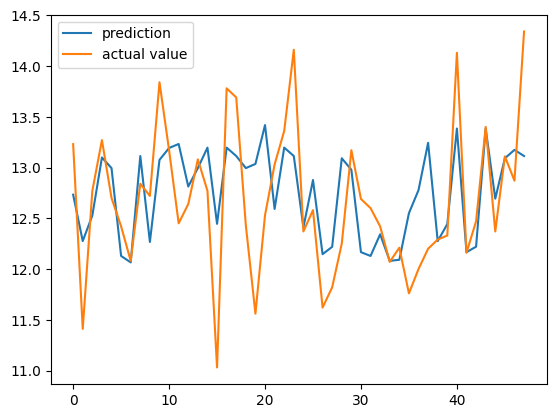

In [ ]:
# visualize the result
plt.plot(pred, label = 'prediction')
plt.plot(y_test.values, label = 'actual value')
plt.legend()
plt.show()